In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
Tesla T4


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
def load_image(path):
    # ----- Load original image -----
    img = Image.open(path).convert("RGB")
    w, h = img.size
    crop_size = min(w, h)
    
    # ----- Define preprocessing -----
    loader = transforms.Compose([
        transforms.CenterCrop(crop_size),
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    # ----- Apply preprocessing -----
    processed = loader(img).unsqueeze(0)

    # ----- Display original image -----
    plt.figure(figsize=(6,6))
    plt.title("Original Image (as loaded)")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    # ----- Display cropped + resized image (before normalization) -----
    # recreate the cropped+resized image for display
    display_transform = transforms.Compose([
        transforms.CenterCrop(crop_size),
        transforms.Resize((512, 512))
    ])
    display_img = display_transform(img)

    plt.figure(figsize=(6,6))
    plt.title("Cropped + Resized Image (512x512)")
    plt.imshow(display_img)
    plt.axis("off")
    plt.show()

    return processed

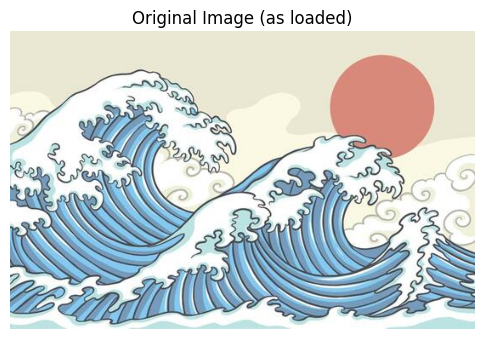

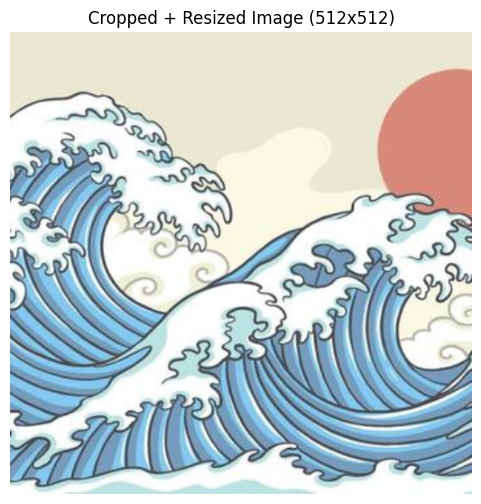

In [42]:
stimg=load_image("/kaggle/input/style-2/traditional-japanese-art-style-wave-theme-free-vector.jpg")


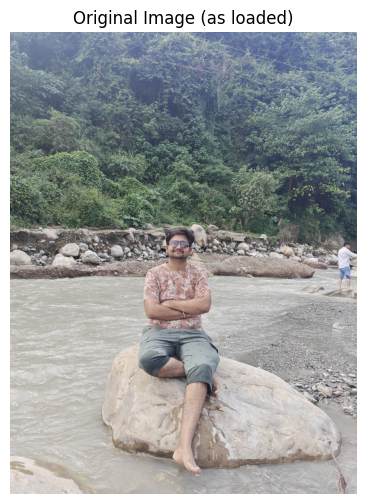

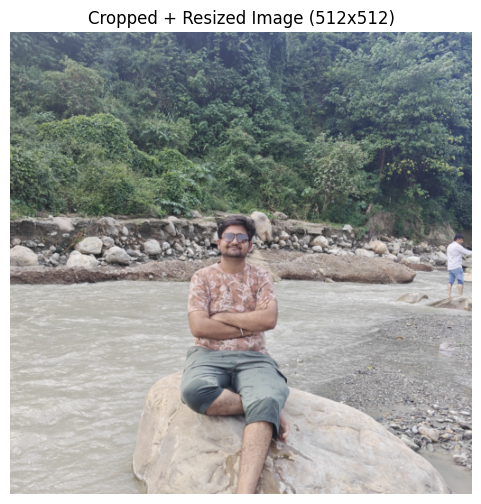

In [25]:
cimg=load_image("/kaggle/input/style-transfer-data-set/c_2.jpeg")

In [17]:
vgg=models.vgg19(pretrained=True).features
vgg=vgg.eval()
for para in vgg.parameters():
    para.requires_grad=False

vgg = vgg.to(device)

In [18]:
def get_features(img):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',   # content layer
        '28': 'conv5_1'
    }
    x=img
    ans={}
    for name,layer in vgg._modules.items():
        x=layer(x)
        if name in layers:
            ans[layers[name]]=x

    return ans

In [19]:
def unnormalize(tensor):
    device = tensor.device  # get whether it's cuda or cpu
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)

    return tensor * std + mean

In [20]:
def show_image(tens):
    if tens.dim() == 4:  
        tens = tens.squeeze(0)   # (3,H,W)
    
    unnor = unnormalize(tens.unsqueeze(0))   # (1,3,H,W)
    unnor = unnor.squeeze(0)                 # (3,H,W)

    unnor = unnor.permute(1,2,0).detach().cpu().numpy()
    unnor = unnor.clip(0,1)
    plt.figure(figsize=(6,6))
    plt.imshow(unnor)
    plt.axis("off")
    plt.show()

In [21]:
def content_loss_function(gen_features, content_features):
    return torch.mean((gen_features-content_features)**2)

def gram_matrix(x):
    _,c,h,w=x.size()
    x=x.view(c,h*w)
    return (x@x.t())/(h*w)

def style_loss_function(gen_features, style_features):
    return torch.mean((gram_matrix(gen_features)-gram_matrix(style_features))**2)

Step: 50, Total loss: 137.8216
Step: 100, Total loss: 69.7051
Step: 150, Total loss: 47.8879
Step: 200, Total loss: 37.0438
Step: 250, Total loss: 30.6049
Step: 300, Total loss: 26.3312


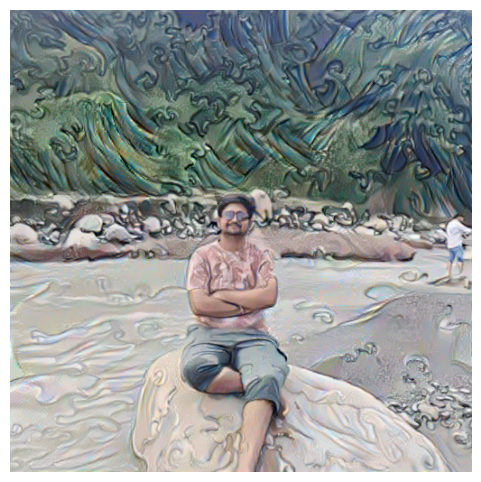

Step: 350, Total loss: 23.2418
Step: 400, Total loss: 21.0912
Step: 450, Total loss: 19.1658
Step: 500, Total loss: 17.8413
Step: 550, Total loss: 16.6784
Step: 600, Total loss: 15.6341


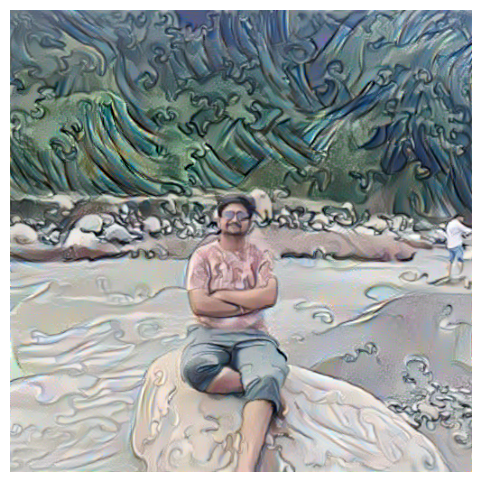

Step: 650, Total loss: 14.6920
Step: 700, Total loss: 13.8995
Step: 750, Total loss: 13.2423
Step: 800, Total loss: 12.6939
Step: 850, Total loss: 12.1899
Step: 900, Total loss: 11.6741


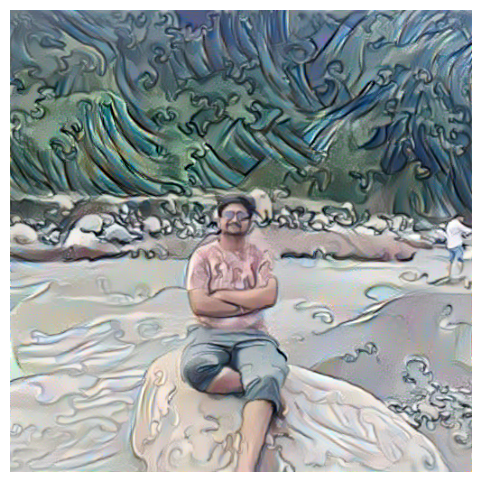

Step: 950, Total loss: 11.2540
Step: 1000, Total loss: 10.8968
Step: 1050, Total loss: 10.5723
Step: 1100, Total loss: 10.2457
Step: 1150, Total loss: 10.0248
Step: 1200, Total loss: 9.8546


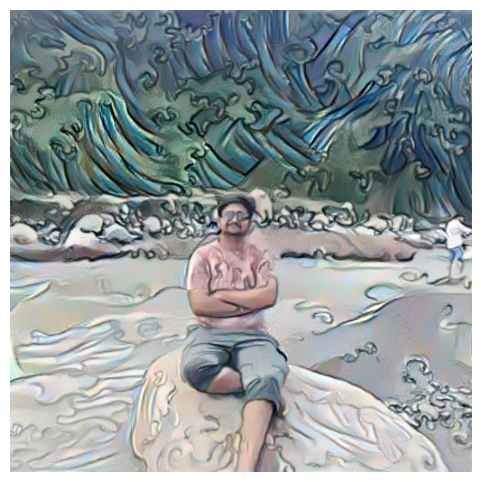

Step: 1250, Total loss: 9.6521
Step: 1300, Total loss: 9.4358
Step: 1350, Total loss: 9.2739
Step: 1400, Total loss: 8.9030
Step: 1450, Total loss: 8.6695
Step: 1500, Total loss: 8.4056


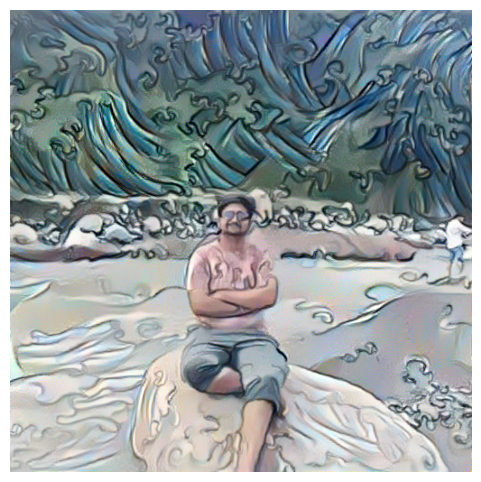

Step: 1550, Total loss: 8.3266
Step: 1600, Total loss: 8.3366
Step: 1650, Total loss: 8.1093
Step: 1700, Total loss: 7.9783
Step: 1750, Total loss: 7.6753
Step: 1800, Total loss: 7.7336


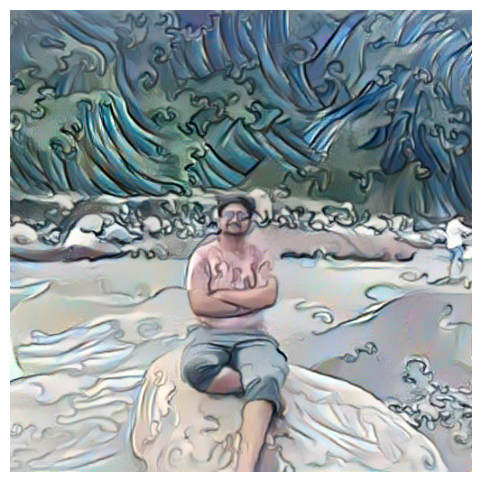

Step: 1850, Total loss: 7.7278
Step: 1900, Total loss: 7.5675
Step: 1950, Total loss: 7.4233
Step: 2000, Total loss: 7.1312
Step: 2050, Total loss: 6.9650
Step: 2100, Total loss: 6.8511


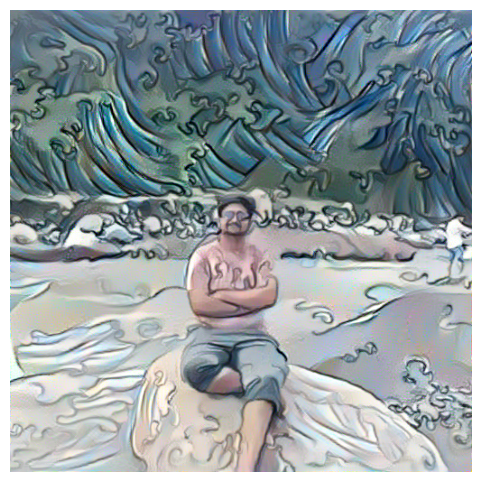

Step: 2150, Total loss: 7.1889
Step: 2200, Total loss: 14.5139
Step: 2250, Total loss: 8.4422
Step: 2300, Total loss: 7.4028
Step: 2350, Total loss: 6.9186
Step: 2400, Total loss: 6.6389


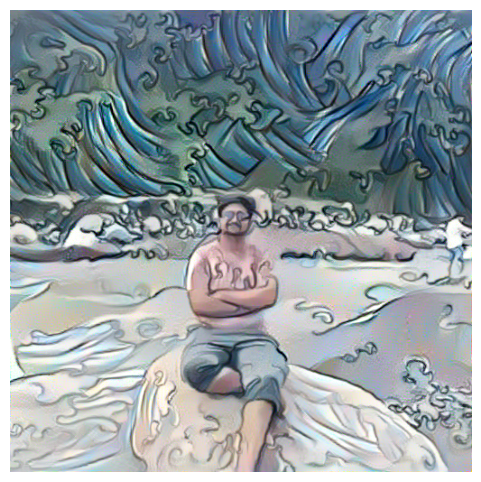

Step: 2450, Total loss: 6.5166
Step: 2500, Total loss: 6.2606
Step: 2550, Total loss: 6.2163
Step: 2600, Total loss: 6.0275
Step: 2650, Total loss: 6.0455
Step: 2700, Total loss: 5.9114


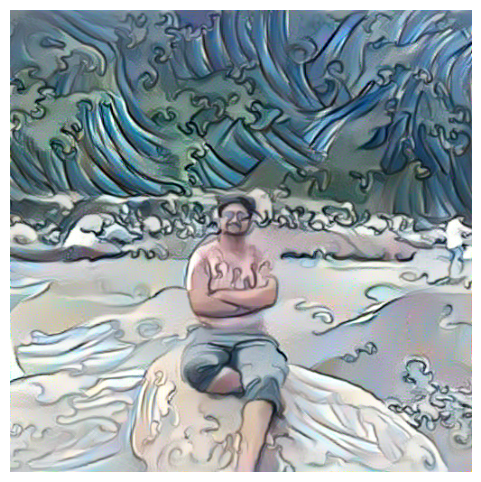

In [44]:
cimg = cimg.to(device)
stimg = stimg.to(device)
generated = cimg.clone().to(device).requires_grad_(True)

optimizer = torch.optim.Adam([generated], lr=0.015)

num_steps = 2700

style_layers = ['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1']

for step in range(1, num_steps + 1):

    optimizer.zero_grad()

    # ---------------------------------------------------------
    # 1. GET FEATURES FROM VGG
    #    (You must create a function: get_features(image))
    # ---------------------------------------------------------
    gen_features = get_features(generated)
    content_features = get_features(cimg)
    style_features = get_features(stimg)

    # ---------------------------------------------------------
    # 2. COMPUTE LOSSES
    #    (You must create:
    #     - content_loss_function()
    #     - style_loss_function()
    #     - gram_matrix()
    #    )
    # ---------------------------------------------------------
    c_loss = content_loss_function(gen_features['conv4_2'], content_features['conv4_2'])
    s_loss = 0
    for layer in style_layers:
        g = gen_features[layer]
        s = style_features[layer]
        s_loss += style_loss_function(g, s)


    total_loss =  75 * s_loss   # weight style more

    # ---------------------------------------------------------
    # 3. BACKPROP + OPTIMIZE
    # ---------------------------------------------------------
    total_loss.backward()
    optimizer.step()

    # ---------------------------------------------------------
    # 4. SHOW IMAGE EVERY 100 ITERATIONS
    #    (You must create function show_image(tensor))
    # ---------------------------------------------------------
    if step%50==0:
        print(f"Step: {step}, Total loss: {total_loss.item():.4f}")
    if step % 300 == 0:
        show_image(generated)